## Context

In this project, we were asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C. The data is for the years of 2011 and 2012. This dataset was provided by Hadi Fanaee Tork using data from Capital Bikeshare [6]. 

The same project was a competition on Kaggle [2] 4 years ago. 

![kaggle.png](kaggle.png)

# Data Exploration


## The Dataset

To prevent future issues when predicting rental counts, we begin by familiarising ourselves with the dataset, starting with a simple analysis, exploring details step by step. 

In [2]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

In [7]:
df = pd.read_csv("BikeRental.csv")
df.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

In [4]:
df.shape

(17379, 17)

We have 17379 rows of data, with 17 columns. 

In [8]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

Looking at the data, we start speculating about its structure as we observe the following:

- All columns except `dteday` appear to contain numerical values. 
- Values related to weather data (`temp`, `atemp`, `hum`, `windspeed`) might be scaled, as they range in the 0.XX area. 
- Values in the instant column increase by 1 and appear to be related to the row number. 

So we dig deeper to understand more about the structure of the dataset. 

## Searching for Missing Values

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


This confirms our suspicions that we are in fact dealing with numeric columns only (except dteday).

In [11]:
df.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

To our surprise, none of the columns contain NaN values, which we suppose will reduce the effort we have to put into cleaning the data later on. However, there are some missing values that can go un-noticed. Let us plot a distribution of how many days have how many data points. 

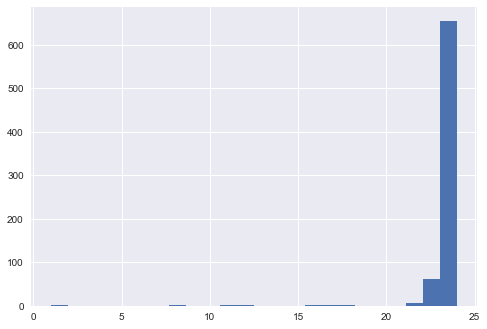

In [39]:
hours_per_day = df.groupby('dteday').count()['instant'].hist(bins=24)

While most of the days have data for the full 24 hours, some days have a few hours of data missing. Hours with missing data in this context can mean one of two things: 1) the data is legitly missing so we need to correct for it or 2) hours missing from the data indicate a total count of rentals equal to 0, meaning no bikes were rented at that time. For case 2 we will not have to correct, so we check the data for existing 0 counts.

In [9]:
0 in df.cnt.values

False

Good news! Cnt contains no 0 values, so we can safely assume we are dealing with case 2 here, "hours absent from the dataset indicate no rentals at that hour".

## Statistics

We now start analysing each column, running statistics.

In [10]:
df.describe()

instant        season            yr          mnth            hr  \
count  17379.0000  17379.000000  17379.000000  17379.000000  17379.000000   
mean    8690.0000      2.501640      0.502561      6.537775     11.546752   
std     5017.0295      1.106918      0.500008      3.438776      6.914405   
min        1.0000      1.000000      0.000000      1.000000      0.000000   
25%     4345.5000      2.000000      0.000000      4.000000      6.000000   
50%     8690.0000      3.000000      1.000000      7.000000     12.000000   
75%    13034.5000      3.000000      1.000000     10.000000     18.000000   
max    17379.0000      4.000000      1.000000     12.000000     23.000000   

            holiday       weekday    workingday    weathersit          temp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.028770      3.003683      0.682721      1.425283      0.496987   
std        0.167165      2.005771      0.465431      0.639357      0.192556   
min        0.000000      0.000000      0.000000      1.000000      0.020000   
25%        0.000000      1.000000      0.000000      1.000000      0.340000   
50%        0.000000      3.000000      1.000000      1.000000      0.500000   
75%        0.000000      5.000000      1.000000      2.000000      0.660000   
max        1.000000      6.000000      1.000000      4.000000      1.000000   

              atemp           hum     windspeed        casual    registered  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.475775      0.627229      0.190098     35.676218    153.786869   
std        0.171850      0.192930      0.122340     49.305030    151.357286   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.333300      0.480000      0.104500      4.000000     34.000000   
50%        0.484800      0.630000      0.194000     17.000000    115.000000   
75%        0.621200      0.780000      0.253700     48.000000    220.000000   
max        1.000000      1.000000      0.850700    367.000000    886.000000   

                cnt  
count  17379.000000  
mean     189.463088  
std      181.387599  
min        1.000000  
25%       40.000000  
50%      142.000000  
75%      281.000000  
max      977.000000

Looking at these values and going back to our suspicions about the dataset, we can now observe and deduct the following: 

- The `instant` column ranges from 1 to 17379, which equals the number of rows the dataset has. Its mean, 25%, 50% and 75% values also support the assumption that the column is used as an incremental index. 
- The `season` column contains integers between 1 and 4 with a mean at ~2.5. Hence, we assume they are distributed equally. 
- The `year` column encodes two years as either 0 or 1 with a mean above 0.5, meaning one year is represented more often in the data than the other. 
- The `month` column ranges from 1 to 12, encoding each month as an integer. 
- `hours` are encoded as integers between 0 and 23. 
- `holiday` is a binary encoding using 0 and 1 with a mean that is very small, hinting at holidays being underrepresented in the data, which is to be expected. 
- `weekday` ranged from 0 to 6, encoding each day of the week. 
- `workingday` is, just like holiday, a binary encoding using 0 and 1. 
- `weathersit` is an integer column with values between 1 and 4. 
- `temp`, contrary to our suspicion earlier does not start at 0 but at 0.02 instead. It goes all the way to 1 and has a mean of just under 0.5. We hence expect to see a somewhat uniform distribution of temperature encoded values in the data. 
- `atemp` is by all means very close to temp, making us question the columns usefulness for further analysis. 
- `humidity` ranges from 0 to 1. 
- `windspeed` starts at 0 but goes up only to a value of 0.85. 
- numbers for `casual` users are a lot lower than for `registered` ones, indicating that both groups might need to be reviewed in more detail separately from another. 
- The *maximum* number of bikes rented in one hour is 977. 

Out of curiosity, we look for the day when the highest count of total rentals is achieved. We find that on this day and hour, 886 registered users were riding bikes, supplemented only by 91 casual users. This further hints at an imbalance of registered vs. casual users in the data, leaning heavily towards the former.

In [13]:
df[df['cnt'] == df['cnt'].max()]

instant      dteday  season  yr  mnth  hr  holiday  weekday  \
14773    14774  2012-09-12       3   1     9  18        0        3   

       workingday  weathersit  temp   atemp   hum  windspeed  casual  \
14773           1           1  0.66  0.6212  0.44     0.2537      91   

       registered  cnt  
14773         886  977

We now proceed to create a summary view of the data in each column.

In [10]:
asc_cols = ['season','mnth','weekday','hr'] # columns we want to see in different order or more than just the top 10 of
skip_cols = ['temp','atemp','hum','windspeed','instant','dteday'] # columns we are skipping because they are scaled or an index

for (columnName, columnData) in df.iteritems():
    if columnName not in skip_cols:
        if columnName in asc_cols:
            print(f'Column Name: {columnName}')
            print(columnData.value_counts().nlargest(24).sort_index())
            print(f'\n')
        else:
            print(f'Column Name: {columnName}')
            print(columnData.value_counts().nlargest(10))
            print(f'\n')

Column Name: season
1    4242
2    4409
3    4496
4    4232
Name: season, dtype: int64


Column Name: yr
1    8734
0    8645
Name: yr, dtype: int64


Column Name: mnth
1     1429
2     1341
3     1473
4     1437
5     1488
6     1440
7     1488
8     1475
9     1437
10    1451
11    1437
12    1483
Name: mnth, dtype: int64


Column Name: hr
0     726
1     724
2     715
3     697
4     697
5     717
6     725
7     727
8     727
9     727
10    727
11    727
12    728
13    729
14    729
15    729
16    730
17    730
18    728
19    728
20    728
21    728
22    728
23    728
Name: hr, dtype: int64


Column Name: holiday
0    16879
1      500
Name: holiday, dtype: int64


Column Name: weekday
0    2502
1    2479
2    2453
3    2475
4    2471
5    2487
6    2512
Name: weekday, dtype: int64


Column Name: workingday
1    11865
0     5514
Name: workingday, dtype: int64


Column Name: weathersit
1    11413
2     4544
3     1419
4        3
Name: weathersit, dtype: int64


Column Name: casua

Looking through these summaries, we can establish a few things:
    
- Data is not spread equaly across seasons. Winter (1) and Fall (4) have ~5% less data than Spring and Summer
- Year 0 is slightly less often represented in the data than year 1, confirming our earlier suspicions
- Months are fairly even in count, with the exception of February. This might be due to the fact February natrually is the shortest month of the year
- The highest density of data is present for 4 PM, with later hours being very close until 1 AM. Building upon our earlier finding, we can deduct less people ride bikes between 2 AM to 5 AM as       these are underrepresented in the data
- There is an expected imbalance of non-holidays in the data
- Weekday and workingday show expected ratios
- There is a heavy imbalance in weathersit data, with situation 4 being represented only 3 times, whilst situation 1 makes up ~65% of all data
- Notably the count of casual users with the highest number of occourcances is 0 people, followed by 1 person
- By contrast, small bands of registered users are the most common in the data, impacting the frequency of the cnt variable  

## Correlation

Armed with this general understanding of the data, we dive deeper to identify how the columns correlate with one another. We built a custom script to do this, called `correl_plot`. 

In [182]:
import correl_plot as cp

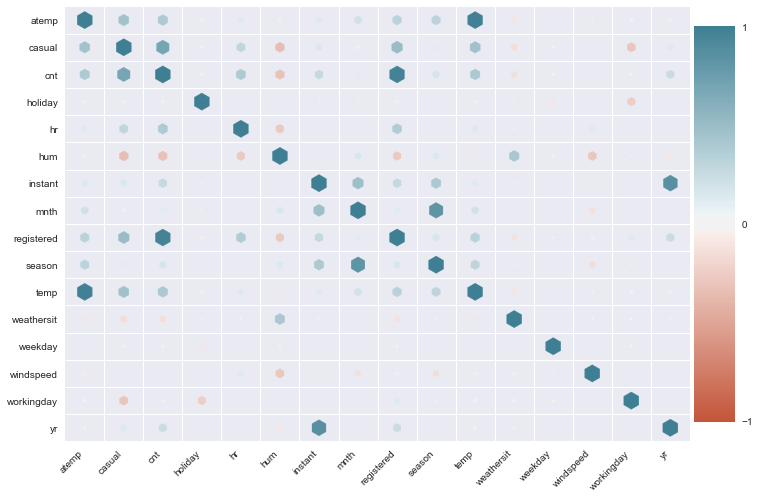

In [183]:
correl_ = cp.df_to_hexag(df)

For the correlation matrix a format is chosen that already provides visual indicators using color, opacity, and shape size. The bigger and less opaque a shape, the higher the correlation between the two columns it connects. Positive correlation is colored blue, negative correlation red. The image above gives important insight into how strongly columns are linked, with the following findings being the most important:

1. The vast majority of columns in the dataset are not correlated or the link is extremely weak
2. There are a lot more strong positive correlations than there are negative ones
3. The strongest correlations follow logical expectations about the data:

    a. Real temperature and felt temperature are strongly correlated. <br/>
    b. Weather situation has a positive correlation with humidity but a very weak negative correlation with registered users. <br/>
    c. Humidity has the strongest negative correlations with casual and registered users, hence also influencing the total count of users negatively. <br/>
    d. Working day is negatively correlated with casual users but slightly positive with registered users. 

## Distribution

Now, let us see how our data is distributed. We first import our plotting libraries. 

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns

### Distribution of Rentals by Season

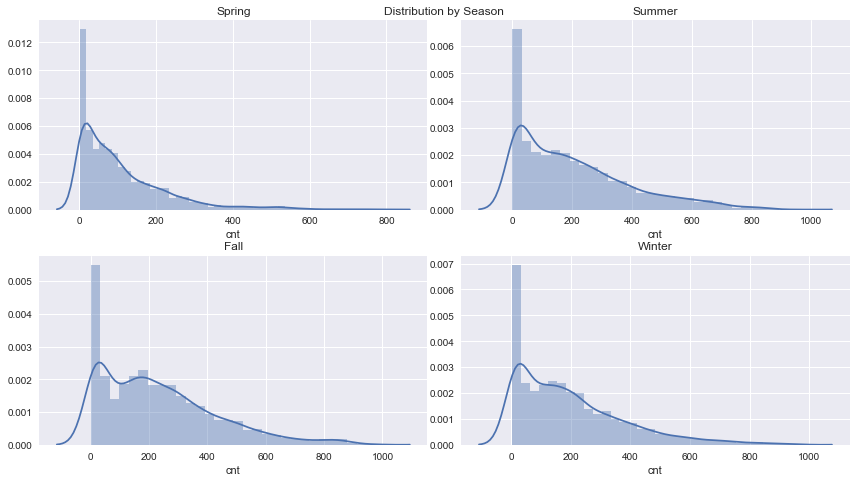

In [185]:
fig, ax = plt.subplots(figsize = [12, 7])
plt.axis('off')
plt.title("Distribution by Season")
labels = ['Spring', 'Summer', 'Fall', 'Winter']
for i, col in enumerate(df['season'].unique()):
    ax = fig.add_subplot(2, 2, i+1)
    sns.distplot(df[df['season']==col]['cnt'], ax=ax)
    plt.title(labels[i])
plt.tight_layout(h_pad=0.2, w_pad=0.2)

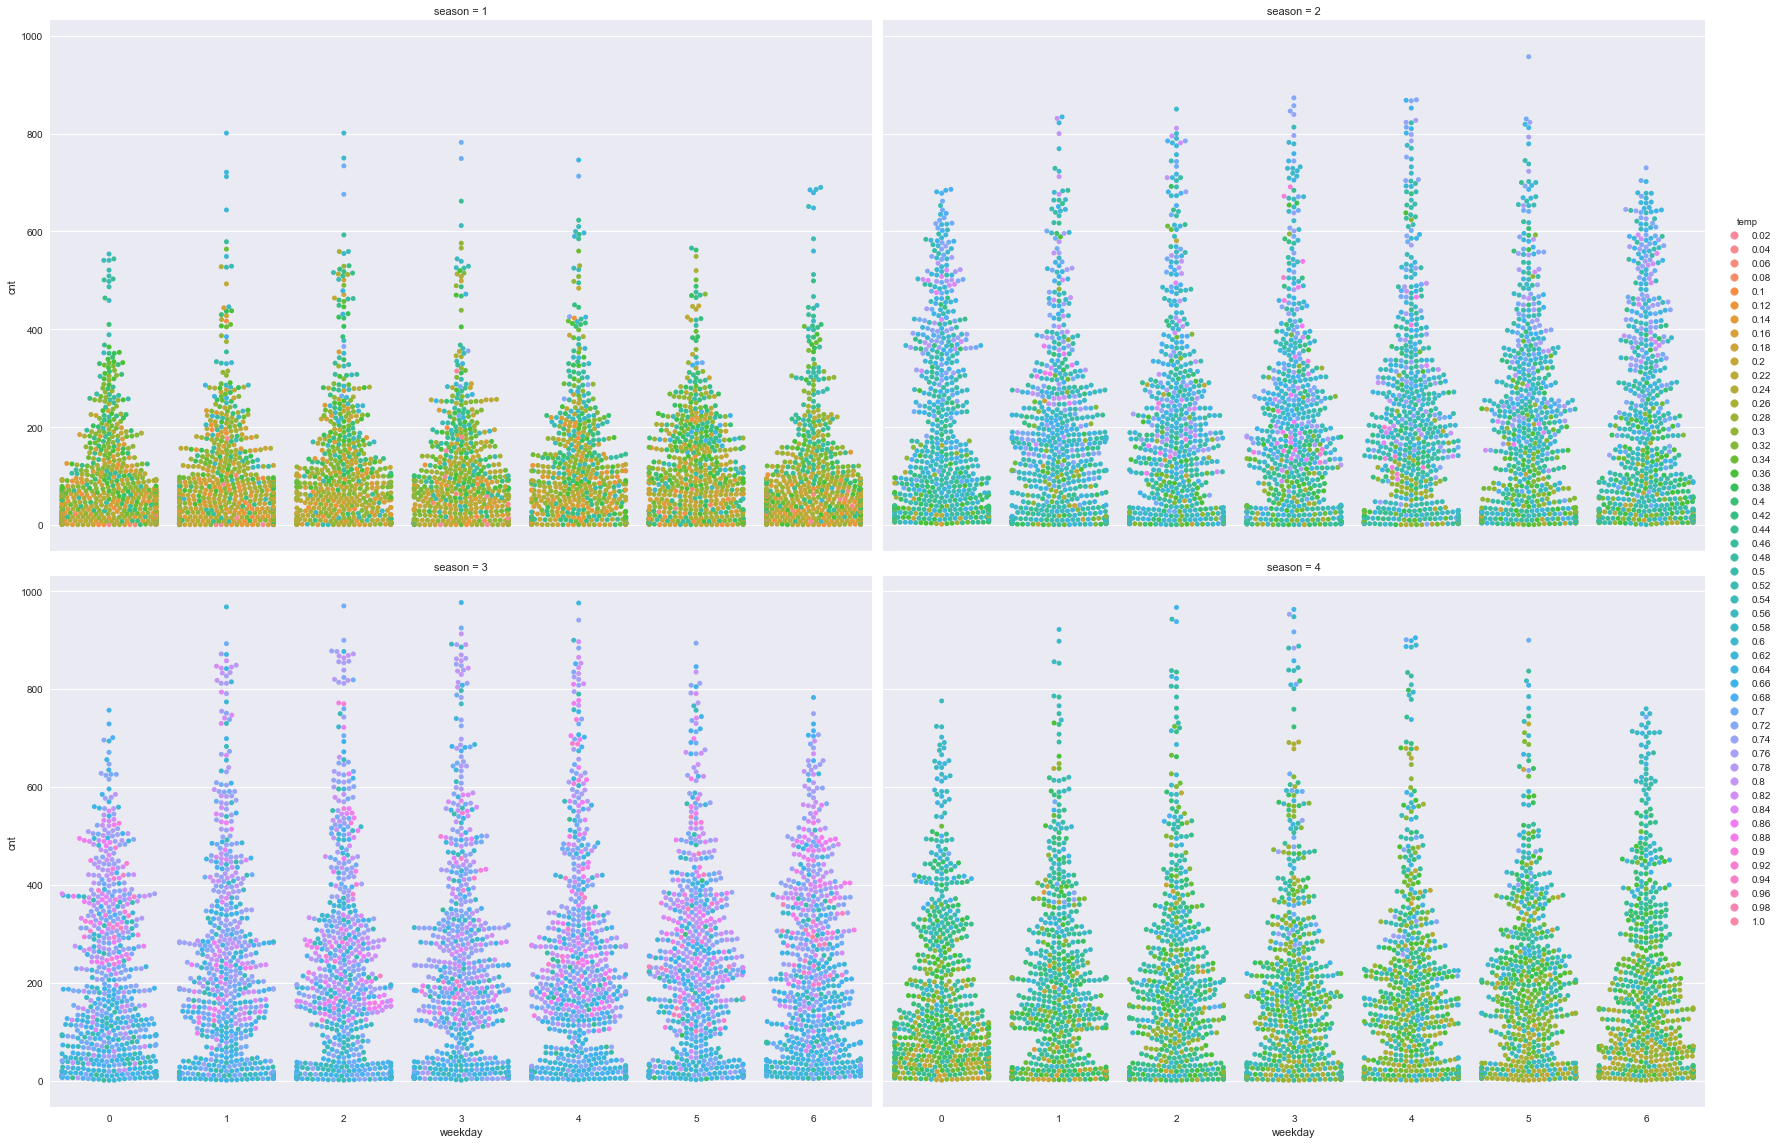

In [213]:
g = sns.catplot(x="weekday", y="cnt", hue="temp", col="season", col_wrap=2, 
                data=df, kind="swarm", height=8, aspect=1.5)

The distribution is similar for all seasons, but the absolute count may vary. 

### Distribution of Rentals by Weather Situation

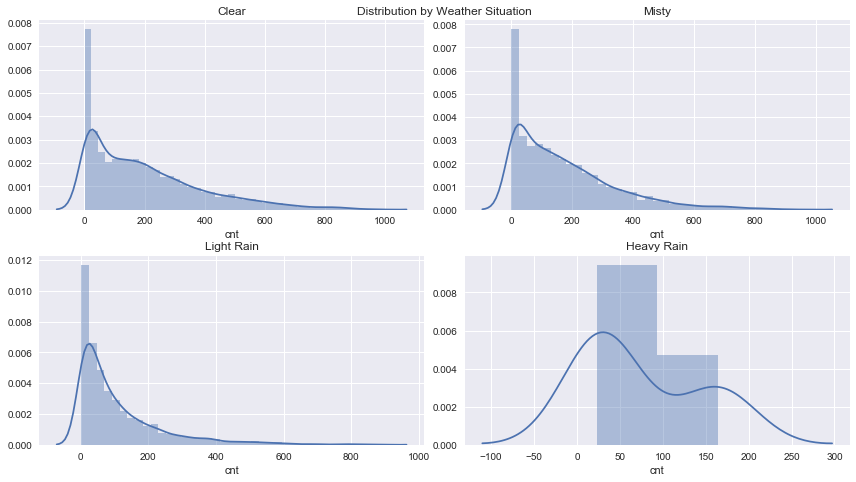

In [186]:
fig, ax = plt.subplots(figsize = [12, 7])
plt.axis('off')
plt.title("Distribution by Weather Situation")
labels = ['Clear', 'Misty', 'Light Rain', 'Heavy Rain']
for i, col in enumerate(df['weathersit'].unique()):
    ax = fig.add_subplot(2, 2, i+1)
    sns.distplot(df[df['weathersit']==col]['cnt'], ax=ax)
    plt.title(labels[i])
plt.tight_layout(h_pad=0.2, w_pad=0.2)

The distributions for the three less extreme weather situations ('Clear','Misty','Light Rain') is very similiar by shape.
Moreover, in magnitude, clear and misty weather conditions are similar as well, while the frequency for much lower usage
during light rain is more pronounced. All three distributions are positively skewed with large, low-frequent observations
in the right tail. Outliers shall be examined in the next section.

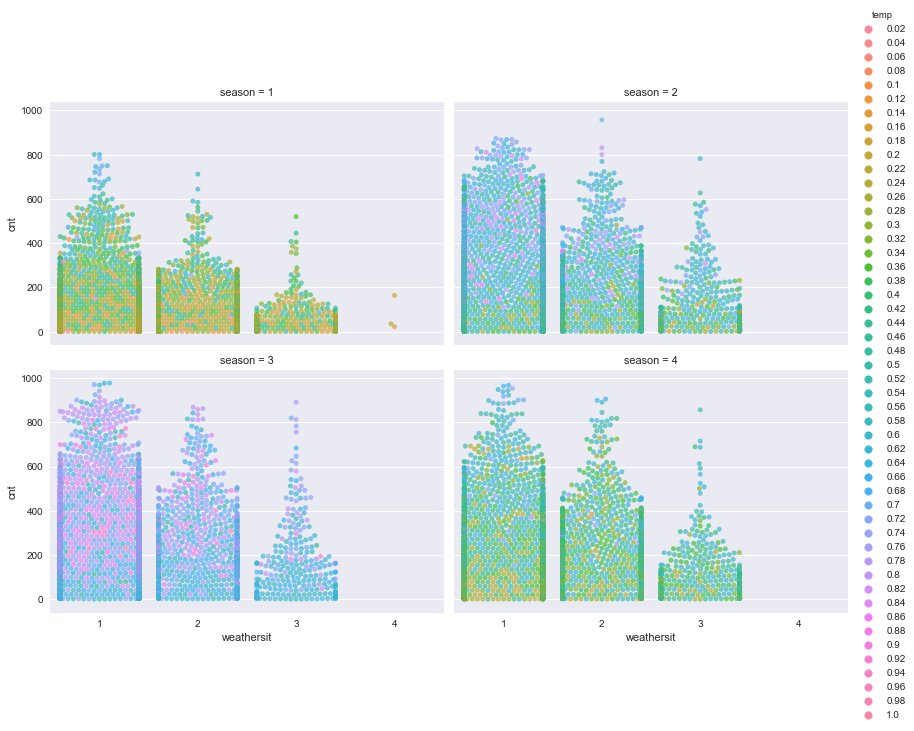

In [227]:
w = sns.catplot(x="weathersit", y="cnt", hue="temp", col="season", col_wrap=2,
                data=df, kind="swarm", height=4, aspect=1.5, alpha=0.7)

Further examining the data set by weather situation, one can see that there are only four data points for heavy rain, which explains the distorted histogram above. Besides that this depiction allows to deduce that the highest user count in each segment and high temperatures are correlated with each other. 

### Distribution by Temperature 

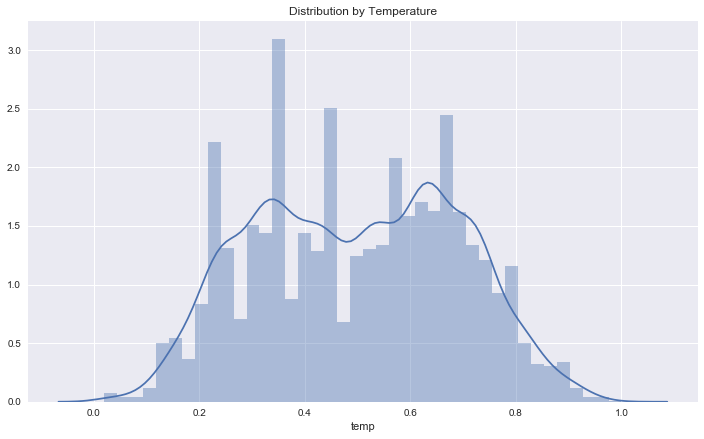

In [188]:
fig, ax = plt.subplots(figsize = [12, 7])
sns.distplot(df['temp'])
plt.title("Distribution by Temperature")
plt.show()

The temperature histogram can be approximated by a bi-modal, quasi-symmetrical distribution with large shoulders
and a less pronounced center. As the data has already been normalized, this shape is not surprising. 

## Outliers

Outliers are data points that differ greatly from the rest of the data set. For numerical data, a common convention to define outliers as observations falling more than 1.5 to 3 times out of the interquartile range of a distribution (with more than 3 times being classified as *extreme outliers*).  These outliers observations should be examined carefully, as their existence can contain valuable information about the gathering of data / measurement process and the distribution of the underlying data. Before eliminating outliers, one hence needs to understand if they arose from measurement errors or if the underlying distribution is leptokurtic (i.e. heavy-tailed, which would impact models assuming a normal distribution). Elimination is then needed if the former is true, or if the outliers would introduce a bias to the analysis.

Hence, one should first understand how many points fall outside the extreme boundaries. Since most features are categorical (see Section 3.1) or have been normalized beforehand, only the user counts (`cnt`, `casual`, `registered`) have to be examined here.

In [207]:
stat_table = df.describe()
cnt = df["cnt"]
casual = df["casual"]
registered = df["registered"]

outlier_table = np.ones([3,2])
def outlier_treatment(sequence, TR=1.5):
    sorted(sequence)
    Q1,Q3 = np.percentile(sequence , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (TR * IQR)
    upper_range = Q3 + (TR * IQR)
    return lower_range,upper_range

In [208]:
k = 0
for user in [cnt, casual, registered]:
    i = 0
    for tr in [1.5,3]:
        lowerbound,upperbound = outlier_treatment(user, TR=tr)
        extreme_outlier = len(user[(user < lowerbound)|(user > upperbound)])/len(user)
        outlier_table[k,i] = extreme_outlier
        i += 1
    k += 1
outlier_table = pd.DataFrame(outlier_table*100)
outlier_table.index = ["cnt","casual", "registered"]
outlier_table.columns = ["TR=1.5","TR=3.0"]
outlier_table

TR=1.5    TR=3.0
cnt         2.905806  0.000000
casual      6.858853  2.825249
registered  3.912768  0.258933

As the results table shows, for the overall count, no observation falls outside the threshold of 3 and hence no extreme outliers are present in the data, and less than 3% lie in between the [1.5 - 3]x interquartile range. 

![Outlier_Cnt_Weekday.png](Outlier_Cnt_Weekday.png)

However, whilst registered user express similar characteristics, casual user have a much higher share of outliers and extreme outliers. This is visualized by an overlay of the respective box plots with a swarmplot split by weekdays. Moreover, besides differences in extreme values, one can observe a difference in user counts by weekdays. This will be further examined in the next section.

![Outlier_Registered_Weekday.png](Outlier_Registered_Weekday.png)

![Outlier_Casual_Weekday.png](Outlier_Casual_Weekday.png)

Overall, cross-checking for the largest outliers using:

In [231]:
df[df['cnt'] == df['cnt'].max()]

instant      dteday  season  yr  mnth  hr  holiday  weekday  \
14773    14774  2012-09-12       3   1     9  18        0        3   

       workingday  weathersit  temp   atemp   hum  windspeed  casual  \
14773           1           1  0.66  0.6212  0.44     0.2537      91   

       registered  cnt  
14773         886  977

In [233]:
df[df['casual'] == df['casual'].max()]

instant      dteday  season  yr  mnth  hr  holiday  weekday  \
10477    10478  2012-03-17       1   1     3  16        0        6   

       workingday  weathersit  temp   atemp  hum  windspeed  casual  \
10477           0           1  0.64  0.6212  0.5        0.0     367   

       registered  cnt  
10477         318  685

In [234]:
df[df['registered'] == df['registered'].max()]

instant      dteday  season  yr  mnth  hr  holiday  weekday  \
14773    14774  2012-09-12       3   1     9  18        0        3   

       workingday  weathersit  temp   atemp   hum  windspeed  casual  \
14773           1           1  0.66  0.6212  0.44     0.2537      91   

       registered  cnt  
14773         886  977

shows that all other features falls in their normal ranges and hence most likely there have been no measurement errors. For these reasons, we decided to not cut off any outliers and keep the data sets as they are.

# Bibliography

1. "Runde Sache". Readers Digest Deutschland (in German). 06/11: 74â€“75. June 2011.
2. https://www.kaggle.com/c/bike-sharing-demand
3. https://www.grandviewresearch.com/industry-analysis/electric-scooters-market
4. https://www.reuters.com/brandfeatures/venture-capital/article?id=122514
5. https://johnnyafrica.com/frankfurt-bike-scooters-share/#E-Scooters_in_Frankfurt
6. https://www.capitalbikeshare.com/system-data
7. https://scikit-learn.org/stable/supervised_learning.html
8. https://keras.io